# Import Necessary Libraries

In [1]:
%load_ext autoreload
#%autoreload 2
# issue with debugging with autoreload

In [2]:


import os
import warnings

import json
import torch
from tqdm import tqdm
import numpy as np
from PIL import Image
import copy

from collections import defaultdict

from models.dynca import DyNCA

os.environ['FFMPEG_BINARY'] = 'ffmpeg'

from utils.misc.display_utils import save_train_image
from utils.misc.preprocess_texture import preprocess_style_image, preprocess_vector_field
from utils.misc.video_utils import VideoWriter, synthesize_video
import matplotlib.pyplot as plt
from utils.misc.flow_viz import flow_to_image, plot_vec_field
from utils.misc.masking import flow_to_mask, water_to_mask, smooth_mask
from utils.loss.loss import Loss
from IPython.display import clear_output, Markdown
from utils.load_files import load_compressed_tensor
import torchvision.transforms as transforms

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
torch.backends.cudnn.deterministic = True

In [3]:
if os.getcwd()[-9:] == "notebooks":
    os.chdir("..")
os.getcwd()

'W:\\Documents\\EPFL\\Semester 4\\CP\\DyNCAwithCLIP'

# Parameter Setting
Use a class to store all parameters in argparse style

In [4]:
class Args:
    def __init__(self):
        # motion loss
        self.img_size = (256, 256) # Controls the image size during training. Corresponds to DyNCA-S/L-img_size in paper
        self.patch_size = 96
        self.new_patch_step = 100
        self.motion_img_size = self.img_size
        self.crop = True
        self.mask = None
        self.mask_smooth = 0
        self.flow_sensibility = 0 # useful for when we create a mask from flow
        self.theta_filters = 0
        self.pretrained_path = "pretrained_models"
        self.output_dir = "out/VectorFieldMotion"
        self.video_length = 10
        self.video_only = False
        self.target_appearance_path = "data/VectorFieldMotion/Appearance/bubbly_0101.jpg"
        self.target_vector_field_path = None
        
        """NCA related arguments"""
        self.nca_pool_size = 128
        self.nca_step_range = [32, 128]
        self.nca_inject_seed_step = 8
        self.nca_c_in = 12 # Input channel of DyNCA, DyNCA-S is 12, DyNCA-L is 16
        self.nca_fc_dim = 96 # Dimensionality of Update MLP in DyNCA. DyNCA-S is 96, DyNCA-L is 128
        self.nca_seed_mode = "zeros" # Initialize seed with zero-filled tensor
        self.nca_padding_mode = 'replicate' # Replicate padding when performing Perception, as introduced in Section 3.3
        self.nca_pos_emb = None# "CPE"
        self.nca_vf_emb = None
        self.nca_perception_scales = [0, 1]
        
        """Loss related arguments"""
        self.appearance_loss_weight = 1.0
        self.appearance_loss_type = "OT"
        self.vector_field_motion_loss_weight = 1.0
        self.motion_strength_weight = 15.0
        self.motion_direction_weight = 10.0 # gamma in Section 4.2.1
        self.motion_weight_change_interval = 500
        self.motion_vector_field_name = "0" # "custom"
        self.target_motion_vec = []
        self.motion_model_name = "two_stream_dynamic"
        self.nca_base_num_steps = 24.0
        self.overflow_loss_weight = 100.0
        
        """Train setting"""
        self.max_iterations = 3000
        self.save_every = 50
        self.batch_size = 4
        self.lr = 1e-3
        self.lr_decay_step = [[1000, 2000]]
        self.DEVICE = "cuda:0"
args = Args()

# Load motion vector field and image

In [5]:
style_img = Image.open(args.target_appearance_path)

cuda:0
target shape: torch.Size([4, 3, 256, 256])
Target Appearance Image: 


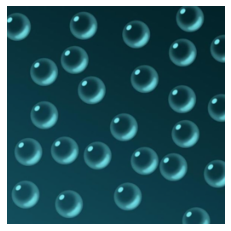

In [6]:
DEVICE = torch.device(args.DEVICE if torch.cuda.is_available() else "cpu")
print(DEVICE)

target_appearance_img = preprocess_style_image(style_img,
                                               img_size=args.img_size,
                                               batch_size=args.batch_size, crop=args.crop) * 2.0 - 1.0  # [-1.0, 1.0]
print(f"target shape: {target_appearance_img.shape}")

print("Target Appearance Image: ")
plt.imshow((target_appearance_img[0].permute(1,2,0).numpy() + 1.0) / 2.0)
plt.axis("off")
plt.show()
target_appearance_img = target_appearance_img.to(DEVICE)
update_mask = torch.ones([1,1,1,1]).to(DEVICE)


# Create output folder

In [7]:

'''Create the log folder'''
img_name = args.target_appearance_path.split('/')[-1].split('.')[0]
print(f"Target Appearance: {img_name}")

output_dir = f'{args.output_dir}/{img_name}/{args.motion_vector_field_name}/'
"""
Note that this part might encounter permission issue, depending on your system and setting.
Call sudo if necessary. 
"""
if not args.video_only:
    os_output_dir = "\ ".join(output_dir.split(" "))
    os.makedirs(os_output_dir, exist_ok=True)

Target Appearance: bubbly_0101


## Initialize the Loss class (containing the target vector field).

In [8]:
DynamicTextureLoss = Loss(args)

nca_size_x, nca_size_y = int(args.img_size[0]), int(args.img_size[1])

Target Vector Field:  0
Successfully Loaded two_stream_dynamic model


# Setup training

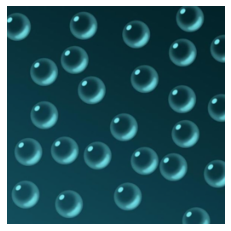

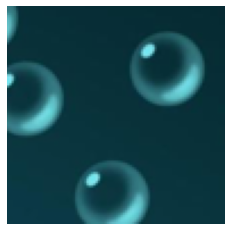

DyNCA param count: 5868


In [9]:
nca_min_steps, nca_max_steps = args.nca_step_range

nca_model = DyNCA(c_in=args.nca_c_in, c_out=3, mask = update_mask,
                  target_vector_field = args.target_motion_vec,
                  fc_dim=args.nca_fc_dim,
                  seed_mode=args.nca_seed_mode,
                  pos_emb=args.nca_pos_emb,
                  vf_emb = args.nca_vf_emb,
                  padding_mode=args.nca_padding_mode,
                  theta_filters=args.theta_filters,
                  perception_scales=args.nca_perception_scales,
                  device=DEVICE, ori_shape=args.img_size)
# chosing a first patch
chosen = False
update_mask_cropped = update_mask
while not chosen or not torch.any(update_mask_cropped):
    j, k, h, w = transforms.RandomCrop.get_params(target_appearance_img, output_size=(args.patch_size, args.patch_size))
    target_cropped = transforms.functional.crop(target_appearance_img, j, k, h, w).to(DEVICE)

    if torch.all(update_mask) :
        # mask is set to 1 everywhere, so no actual mask
        update_mask_cropped = update_mask
    else :
        update_mask_cropped = transforms.functional.crop(update_mask, j, k, h, w)
        nca_model.mask = update_mask_cropped
    chosen = True



with torch.no_grad():
    nca_pool = nca_model.seed(args.nca_pool_size, size=(args.patch_size, args.patch_size),top=j, left=k, img=target_cropped)

plt.imshow((target_appearance_img[0].permute(1,2,0).cpu().numpy() + 1.0) / 2.0)
plt.axis("off")
plt.show()
plt.imshow((target_cropped[0,:3].permute(1,2,0).cpu().numpy() + 1.0) / 2.0)
plt.axis("off")
plt.show()

param_n = sum(p.numel() for p in nca_model.parameters())
print('DyNCA param count:', param_n)

optimizer = torch.optim.Adam(nca_model.parameters(), lr=args.lr)


args_log = copy.deepcopy(args.__dict__) # what is this?
del args_log['DEVICE']
if 'target_motion_vec' in args_log:
    del args_log['target_motion_vec']


if len(args.lr_decay_step) == 0:
    args.lr_decay_step = [[1000, 2000]]

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                    args.lr_decay_step[0],
                                                    0.5)

input_dict = {}  # input dictionary for computing the loss functions
input_dict['target_image_list'] = [target_appearance_img]  # 0,1
input_dict['target_text'] = 'green grass swaying in the wind'  # 'black and white checkerboard' # not used in this notebook

interval = args.motion_weight_change_interval

loss_log_dict = defaultdict(list)
new_size = (nca_size_x, nca_size_y)

pbar = range(args.max_iterations)

# Training code

In [10]:
for i in pbar:
    np.random.seed(i + 424)
    torch.manual_seed(i + 424)
    torch.cuda.manual_seed_all(i + 424)
    with torch.no_grad():
        batch_idx = np.random.choice(args.nca_pool_size, args.batch_size, replace=False)
        input_states = nca_pool[batch_idx]
        seed_injection = False
        ''' Random patch selection '''
        if i % args.new_patch_step == 0 :
            patch_size = args.patch_size
            chosen = False
            while not torch.any(update_mask_cropped) or not chosen:
                j, k, h, w = transforms.RandomCrop.get_params(target_appearance_img, output_size=(patch_size, patch_size))
                target_cropped = transforms.functional.crop(target_appearance_img, j, k, h, w).to(DEVICE)

                if torch.all(update_mask) :
                    # mask is set to 1 everywhere, so no actual mask
                    update_mask_cropped = update_mask
                else :
                    update_mask_cropped = transforms.functional.crop(update_mask, j, k, h, w)
                    nca_model.mask = update_mask_cropped
                chosen = True
            # update losses
            if args.vector_field_motion_loss_weight > 0:
                target_vector_field_cropped = transforms.functional.crop(args.target_motion_vec, j, k, h, w)
                DynamicTextureLoss.loss_mapper["vector_field_motion"].target_motion_vec = target_vector_field_cropped

            nca_pool = nca_model.seed(args.nca_pool_size, size=(patch_size, patch_size), top=j, left=k, img=target_cropped)
            input_states = nca_pool[batch_idx]

        elif i % args.nca_inject_seed_step == 0:
            seed_injection = True
            seed_inject = nca_model.seed(1, size=(args.patch_size, args.patch_size), img=target_cropped, top=j, left=k)
            input_states[:1] = seed_inject[:1]

        '''Get the image before NCA iteration for computing optic flow'''

        nca_states_before, nca_features_before = nca_model.forward_nsteps(input_states, step_n=1)
        z_before_nca = nca_features_before
        image_before_nca = z_before_nca

    step_n = np.random.randint(nca_min_steps, nca_max_steps)
    input_dict['step_n'] = step_n
    nca_states_after, nca_features_after = nca_model.forward_nsteps(input_states, step_n)

    z = nca_features_after
    generated_image = z
    with torch.no_grad():
        generated_image_vis = generated_image.clone()
        generated_image_vis = (generated_image_vis + 1.0) / 2.0

    image_after_nca = generated_image.clone()

    '''Construct input dictionary for loss computation'''
    input_dict['target_image_list'] = [target_cropped]
    input_dict['update_mask'] = update_mask_cropped[:,:3,:,:]
    input_dict['generated_image_list'] = [generated_image]
    input_dict['generated_image_before_nca'] = image_before_nca
    input_dict['generated_image_after_nca'] = image_after_nca

    input_dict['nca_state'] = nca_states_after

    if i % args.save_every == 0:
        batch_loss, batch_loss_log_dict, summary = DynamicTextureLoss(input_dict, return_summary=True)
    else:
        batch_loss, batch_loss_log_dict, _ = DynamicTextureLoss(input_dict, return_summary=False)
        summary = {}

    for loss_name in batch_loss_log_dict:
        loss_log_dict[loss_name].append(batch_loss_log_dict[loss_name])

    if i % interval == 0 and i > 0:
        print("Updating the motion loss weight")
        DynamicTextureLoss.set_loss_weight(loss_log_dict["appearance"], "vector_field_motion")

    with torch.no_grad():
        batch_loss.backward()
        if torch.isnan(batch_loss):
            with open(f'{output_dir}/train_failed.txt', 'w') as f:
                f.write(f'Epochs {i}')
            print('Loss is NaN. Train Failed. Exit.')
            exit()

        for p_name, p in nca_model.named_parameters():
            p.grad /= (p.grad.norm() + 1e-8)  # normalize gradients
            
        optimizer.step()
        optimizer.zero_grad()
        lr_scheduler.step()

        nca_pool[batch_idx] = nca_states_after
        
        if i % args.save_every == 0:
            clear_output(True)
            if 'vector_field_motion-generated_video_flow' in summary:
                generated_flow_vis = summary['vector_field_motion-generated_video_flow'] / 255.0
                gen_flow_show = save_train_image(generated_flow_vis[:4], f"{output_dir}/flow_gen{i}.jpg", return_img = True)

            if 'vector_field_motion-generated_flow_vector_field' in summary:
                generated_flow_vector_field = summary['vector_field_motion-generated_flow_vector_field']
                # generated_flow_vector_field.save(f"{output_dir}/vec_field_gen{i}.png")

            if 'vector_field_motion-target_flow_vector_field' in summary:
                target_flow_vector_field = summary['vector_field_motion-target_flow_vector_field']
                # target_flow_vector_field.save(f"{output_dir}/vec_field_target.png")

            img_show = save_train_image(generated_image_vis.detach().cpu().numpy(), f"{output_dir}/step{i}.jpg", return_img = True)

            '''Dict: loss log, yscale to log (True/False), ylim (True/False)'''
            plot_log_dict = {}
            plot_log_dict['Overflow Loss'] = (loss_log_dict['overflow'], True, True)
            num_plots = 1
            if "appearance" in loss_log_dict:
                num_plots += 1
                plot_log_dict['Texture Loss'] = (loss_log_dict['appearance'], True, True)

            # plot_train_log(plot_log_dict, num_plots, save_path=f"{output_dir}/losses.jpg")

            if "vector_field_motion" in loss_log_dict:
                plot_log_dict = {}
                plot_log_dict['Motion Loss'] = (
                    loss_log_dict['vector_field_motion'], False, False)
                plot_log_dict['Motion Direction Loss'] = (
                    loss_log_dict['vector_field_motion-direction'], False, False)
                plot_log_dict['Motion Strength Loss'] = (
                    loss_log_dict['vector_field_motion-strength'], False, False)
                # plot_train_log(plot_log_dict, 5, save_path=f"{output_dir}/losses_motion.jpg")
            
            plt.figure(figsize = (30, 30))
            
            plt.subplot(3,3,1)
            plt.title("Overflow Loss", fontsize = 20)
            plt.plot(loss_log_dict['overflow'], '.', alpha = 0.5)
            plt.yscale('log')
            
            plt.subplot(3,3,2)
            plt.title("Appearance Loss", fontsize = 20)
            plt.plot(loss_log_dict['appearance'], '.',alpha = 0.5)
            plt.ylim(np.min(loss_log_dict['appearance']) - 0.5, np.quantile(loss_log_dict['appearance'], 0.95) + 0.5)
            
            plt.subplot(3,3,3)
            plt.title("Motion Dynamic Loss", fontsize = 20)
            plt.plot(loss_log_dict['vector_field_motion'], '.', alpha = 0.5)
            
            plt.subplot(3,3,4)
            plt.title("Motion Direction Loss", fontsize = 20)
            plt.plot(loss_log_dict['vector_field_motion-direction'], '.', alpha = 0.5)
            
            plt.subplot(3,3,5)
            plt.title("Motion Strength Loss", fontsize = 20)
            plt.plot(loss_log_dict['vector_field_motion-strength'], '.', alpha = 0.5)
            
            plt.subplot(3,3,6)
            plt.title("Generated Image", fontsize = 20)
            plt.imshow(img_show)
            
            # plt.subplot(3,3,7)
            # plt.title("Generated Optic Flow", fontsize = 20)
            # plt.imshow(gen_flow_show)

            plt.subplot(3,3,7)
            plt.title("Chosen Patch", fontsize = 20)
            plt.imshow((target_cropped.detach()[0].permute(1,2,0).cpu() + 1.0) / 2.0)
            
            plt.subplot(3,3,8)
            plt.axis("off")
            plt.imshow(generated_flow_vector_field)
            
            plt.subplot(3,3,9)
            plt.axis("off")
            plt.imshow(target_flow_vector_field)
            
            plt.show()

            display_dict = copy.deepcopy(batch_loss_log_dict)
            display_str = "\n\n".join([f"**{k} loss** = {display_dict[k]}" for k in display_dict])
            display_str += f"\n\n**lr**: {lr_scheduler.get_lr()[0]} \n\n"
            display_str += f"**Step**: {i} / {args.max_iterations} \n\n"

            display(Markdown(display_str), display_id='stats')

if not args.video_only:
    torch.save(nca_model, f"{output_dir}/model.pth")
else:
    layered_nca = torch.load(f"{output_dir}/model.pth")

KeyboardInterrupt: 

# Generate Video

In [ ]:
print(output_dir)
synthesize_video(args, nca_model, args.video_length, output_dir, args.target_appearance_path, args.target_vector_field_path, video_name="small", nca_step=int(args.nca_base_num_steps),seed_size=(96,96))

# Generate videos with large size WITHOUT re-training.

In [ ]:
synthesize_video(args, nca_model, args.video_length, output_dir, args.target_appearance_path, args.target_vector_field_path, video_name="original", nca_step=int(args.nca_base_num_steps),seed_size=args.img_size)